# 1. Layers
### 1.1. Convolution Layer

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

def cls():
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()

In [17]:
from sklearn.datasets import load_sample_images

images = load_sample_images()
images.keys()

dict_keys(['images', 'filenames', 'DESCR'])

In [18]:
images = images['images'] # It return 2 images
print("Original shape: ", images[0].shape)
images = tf.keras.layers.CenterCrop(70,120)(images)
images = tf.keras.layers.Rescaling(1/255)(images)
images.shape

Original shape:  (427, 640, 3)


TensorShape([2, 70, 120, 3])

In [20]:
cls()
cl = tf.keras.layers.Conv2D(filters=32, kernel_size=7) # 32*7*7*3
fmaps = cl(images)
fmaps.shape

TensorShape([2, 64, 114, 32])

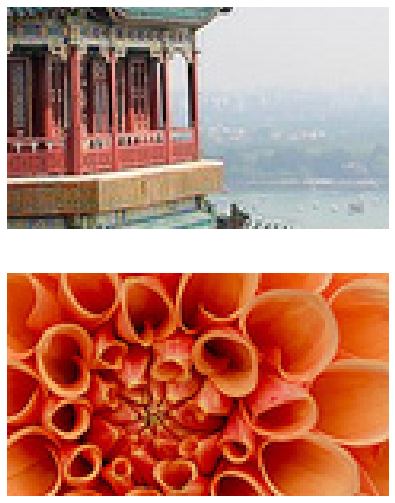

In [42]:
# Displaying original image
plt.figure(figsize=(15, 9))
for image_idx in range(images.shape[0]):
    plt.subplot(2,1,image_idx+1)
    plt.imshow(images[image_idx])
    plt.axis("off")

plt.show()

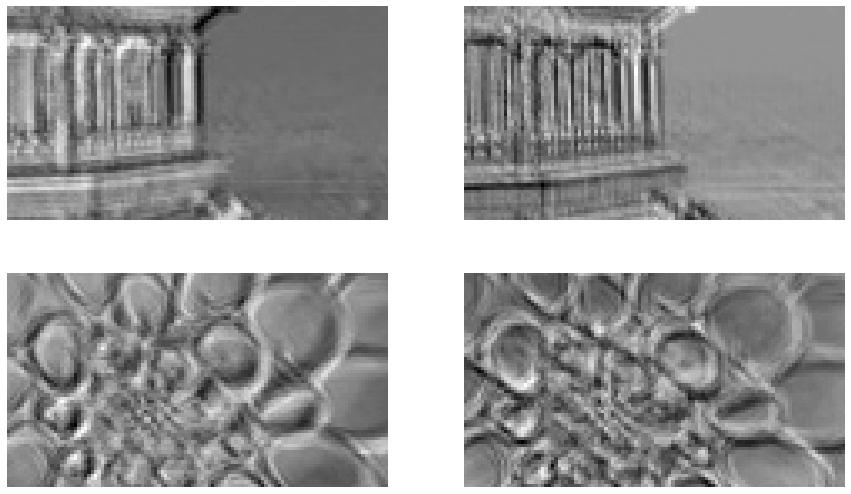

In [46]:
#displays the two output feature maps for each image
plt.figure(figsize=(15, 9))
for image_idx in range(fmaps.shape[0]):
    for fmap_idx in range(fmaps.shape[-1]-30): # only two filters showing
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As we can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

In [50]:
# Without zero padding
print("Image shape : ",images.shape)
fmaps = tf.keras.layers.Conv2D(32,7)(images)
fmaps.shape

Image shape :  (2, 70, 120, 3)


TensorShape([2, 64, 114, 32])

In [51]:
# Using zero padding
print("Image shape : ",images.shape)
fmaps = tf.keras.layers.Conv2D(32,7,padding='same')(images)
fmaps.shape

Image shape :  (2, 70, 120, 3)


TensorShape([2, 70, 120, 32])

In [55]:
# Using Stride=2  Image size will reduce
print("Image shape : ",images.shape)
fmaps = tf.keras.layers.Conv2D(32,7,padding='same',strides=2)(images)
fmaps.shape

Image shape :  (2, 70, 120, 3)


TensorShape([2, 35, 60, 32])

In [56]:
# this utility function can be useful to compute the size of the
# feature maps output by a convolutional layer. It also returns
# the number of ignored rows or columns if padding="valid", or the
#  number of zero-padded rows or columns if padding="same"
# Z = ((N + 2P - F)/S) + 1

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")


(array([35, 60], dtype=int32), array([5, 5]))

In [59]:
conv_layer = tf.keras.layers.Conv2D(32, 7, padding='same',strides=2)
fmaps = conv_layer(images)
kernels, biases = conv_layer.get_weights()
kernels.shape, biases.shape
# 7*7*3 represent as a single neuron we have 32 here + 32 bias terms

((7, 7, 3, 32), (32,))

In [63]:
#shows how to use the tf.nn.conv2d() operation
# This is low level API. we manually assign filter. If we want to 
cls()
filters = tf.random.normal([7, 7, 3, 2]) # 2 neurons 
biases = tf.zeros([2]) # two bias
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases
fmaps.shape

TensorShape([2, 70, 120, 2])

Let's manually create two filters full of zeros, except for a vertical line of 1s in the first filter, and a horizontal one in the second filter (just like in Figure 14–5). The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually, since the convolutional layers will learn them automatically.

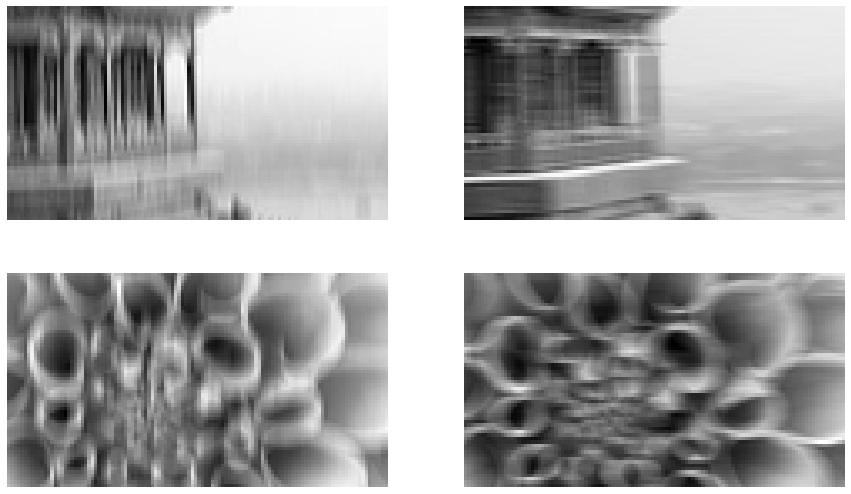

In [77]:
# With valid padding
cls()
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1 # Vertical edge detector
filters[3, :, :, 1] = 1 # Horizontal edge detector
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="VALID")  + biases
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

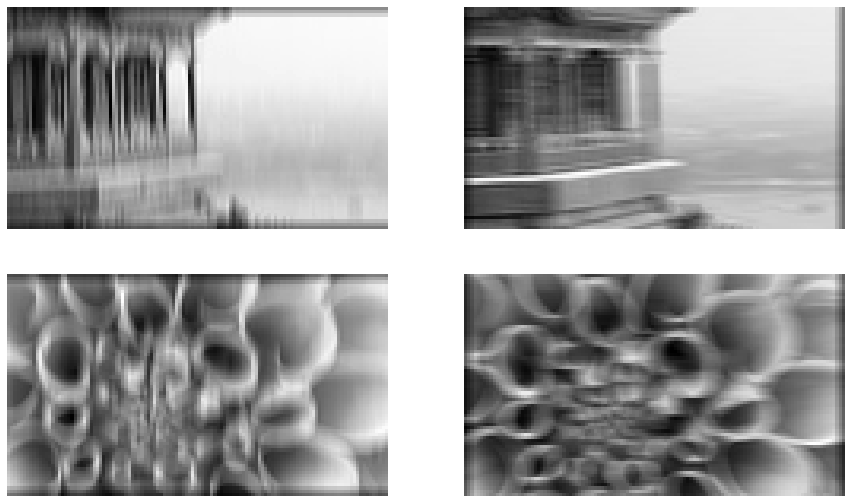

In [78]:
# With Same padding
cls()
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1 # Vertical edge detector
filters[3, :, :, 1] = 1 # Horizontal edge detector
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME")  + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

### 1.2. Pooling Layer

In [105]:
print("Img shape: ", images.shape)
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)# 2*2 matrix
output = max_pool(images)
output.shape

Img shape:  (2, 70, 120, 3)


TensorShape([2, 35, 60, 3])

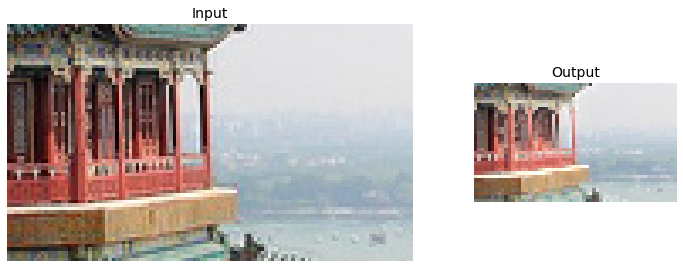

In [87]:
# what max pooling with stride = 2 looks like
import matplotlib as mpl
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [109]:
######################
# Depth-Wise Pooling #
######################
# Pooling layer took the pool over filters.
# shows how to use the max_pool() op; only works on the CPU
# If we want to take pool over combination of filters
# Like taking pool of group of filters then deepwise pooling use
#
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, 
                            ksize=(1, 1, 1, 3), 
                            strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [118]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        #tf.print(inputs, new_shape)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [119]:
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

In [120]:
DepthPool(pool_size=3)(fmaps)[0,0,0], output[0,0,0]

(<tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([0.9507143 , 0.5986585 , 0.8661761 , 0.96990985, 0.83244264,
        0.52475643, 0.6118529 , 0.36636186, 0.785176  , 0.59241456,
        0.60754484, 0.965632  , 0.684233  , 0.4951769 , 0.9093204 ,
        0.66252226, 0.96958464, 0.93949896, 0.9218742 , 0.32533032],
       dtype=float32)>,
 <tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([0.9507143 , 0.5986585 , 0.8661761 , 0.96990985, 0.83244264,
        0.52475643, 0.6118529 , 0.36636186, 0.785176  , 0.59241456,
        0.60754484, 0.965632  , 0.684233  , 0.4951769 , 0.9093204 ,
        0.66252226, 0.96958464, 0.93949896, 0.9218742 , 0.32533032],
       dtype=float32)>)

Shape:  (2, 70, 120, 1)


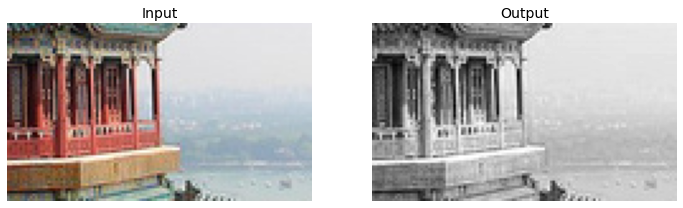

In [126]:
#computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(images)
print("Shape: ", depth_output.shape)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

In [128]:
##########################
# Global Average Pooling #
##########################
print(images.shape)
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()(images)
global_avg_pool.shape

(2, 70, 120, 3)


TensorShape([2, 3])

In [129]:
global_avg_pool

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.26011038, 0.10849128]], dtype=float32)>

In [137]:
tf.reduce_mean(images[0,:,:,0]) # single channel average

<tf.Tensor: shape=(), dtype=float32, numpy=0.6433886>

In [140]:
# The above is equivalent to this
print(images.shape)
global_avg_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=[1,2]))
global_avg_pool(images)


(2, 70, 120, 3)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.26011038, 0.10849128]], dtype=float32)>

In [148]:
# MaxPool2D and MaxPooling2D Are same
print(images.shape)
global_avg_pool = tf.keras.layers.MaxPooling2D()
global_avg_pool(images).shape


(2, 70, 120, 3)


TensorShape([2, 35, 60, 3])

# 2. Top Architectures

In [2]:
# lets load the fashion mnist dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
print(X_train_full.shape)
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
print(X_train_full.shape)
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

(60000, 28, 28)
(60000, 28, 28, 1)


### 1. Simple Structure

In [29]:
from functools import partial
cls()
DefaultConv2D = partial(tf.keras.layers.Conv2D, 
                        kernel_size=3, 
                        padding="same",
                        activation="relu", 
                        kernel_initializer="he_normal")
DefaultDense = partial(tf.keras.layers.Dense, 
                        activation='relu',
                        kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=12),
    DefaultConv2D(filters=12),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=24),
    DefaultConv2D(filters=24),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    DefaultDense(units=12),
    tf.keras.layers.Dropout(0.5),
    DefaultDense(units=12),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])
model.summary()                        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 12)        6924      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 12)        1308      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 12)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 24)          2616      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 24)          5

In [5]:
model.compile(loss="sparse_categorical_crossentropy", 
            optimizer="nadam",
            metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test[:10])

Epoch 1/2
1719/1719 [==============================] - 73s 42ms/step - loss: 1.8171 - accuracy: 0.2963 - val_loss: 1.2192 - val_accuracy: 0.6916
Epoch 2/2
313/313 [==============================] - 4s 14ms/step - loss: 1.0585 - accuracy: 0.6883


In [31]:
# 7*7*1 will represent as a single neuron
# so their is total 64 neurons + 64 bias terms
weights, bias = model.get_layer("conv2d").weights
weights.shape, bias.shape

(TensorShape([7, 7, 1, 64]), TensorShape([64]))

In [46]:
print("Predicted classes : ",tf.argmax(y_pred, axis=1))
print("Actual classes    : ",y_test[:10])

Predicted classes :  tf.Tensor([9 2 1 1 6 1 2 2 5 7], shape=(10,), dtype=int64)
Actual classes    :  [9 2 1 1 6 1 4 6 5 7]


### 2. LeNet-5
Yan LeCun present this architecture back in 1999.
LeNet-5
The famous LeNet-5 architecture had the following layers:

Layer	Type	Maps	Size	Kernel size	Stride	Activation
Out	Fully connected	–	10	–	–	RBF
F6	Fully connected	–	84	–	–	tanh
C5	Convolution	120	1 × 1	5 × 5	1	tanh
S4	Avg pooling	16	5 × 5	2 × 2	2	tanh
C3	Convolution	16	10 × 10	5 × 5	1	tanh
S2	Avg pooling	6	14 × 14	2 × 2	2	tanh
C1	Convolution	6	28 × 28	5 × 5	1	tanh
In	Input	1	32 × 32	–	–	–


There were a few tweaks here and there, which don't really matter much anymore, but in case you are interested, here they are:

- MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
- The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.
- Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 (page 8) in the original paper for details.
- The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

### 3. ResNet-34